# Autoencoders
# II. Variational Autoencoder

Теперь займемся обучением вариационных автоэнкодеров (VAE) — проапгрейженной версией AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9.

В этом блокноте мы имплементируем свой вариационный автоэнкодер, введём функцию потерь для VAE, обучим его, посмотрим на то, как он способен кодировать и декодировать рукописные цифры. На основе этого VAE мы сгенерируем новые цифры. В конце посмотрим, как распределены вектора наших изображений в латентном пространстве VAE, отобразив их на плоскость используя [tSNE](https://cs.nyu.edu/~roweis/papers/sne_final.pdf).

## Содержание

- [Подготовка окружения](#environment)

- [Подготовка данных](#data)

- [Архитектура VAE](#architecture_vae)

- [Loss для VAE](#loss)

- [Функции для обучения VAE](#train_vae_func)

- [Обучение VAE](#vae_train)

- [Reconstruction VAE](#reconstruction_vae)

- [Sampling](#sampling_vae)

- [Latent Representation](#latent_rep)

<a id='latent_rep'></a>

    


    
    

<a id='environment'></a>
## Подготовка окружения
Импортируем необходимые библиотеки

In [ ]:
import warnings
from IPython.display import clear_output
from tqdm import tqdm
from time import time
import seaborn as sns
import os
import pickle
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchsummary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import skimage.io
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patheffects as path_effects
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.2)


warnings.filterwarnings(action='ignore', category=DeprecationWarning)

[Reproducibility (Pytorch):](https://pytorch.org/docs/stable/notes/randomness.html)

In [ ]:
def set_seed(seed):
    """Установить зерно генераторов случайных чисел"""

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def seed_worker(worker_id):
    """Воспроизводимость DataLoader'a (см. ссылку выше)"""

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


set_seed(42)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
!nvidia-smi

Thu Jan  6 18:35:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    34W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Далее будем сохранять лучшие модели

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

DATA_DIR = '/content/gdrive/MyDrive/autoencoders/weights'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


<a id='data'></a>
## Подготовка данных

In [ ]:
batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True,
                               transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False,
                              transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                         shuffle=False)

In [ ]:
print(f'Размер обучающего датасета: {len(train_loader.dataset)}.')

print(f'Размер тестового датасета: {len(test_loader.dataset)}.')

Размер обучающего датасета: 60000.
Размер тестового датасета: 10000.


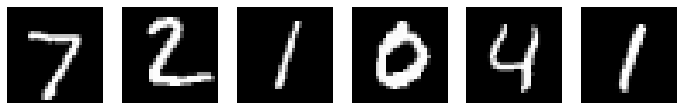

In [ ]:
numbers = next(iter(test_loader))

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(numbers[0][i].squeeze(0).numpy(), cmap='gray')

<a id='architecture_vae'></a>
## Архитектура VAE

Давайте имплементируем Variational autoencoder

<img src="https://upload.wikimedia.org/wikipedia/commons/1/11/Reparameterized_Variational_Autoencoder.png" alt="VariationalAutoencoder"  height="300">

From: [https://en.wikipedia.org/wiki/Variational_autoencoder](https://en.wikipedia.org/wiki/Variational_autoencoder)


У encoder должны быть два "хвоста", т.е. encoder должен кодировать картинку в 2 переменные -- μ и log(σ).

In [ ]:
dim_vae = 8  # Размерность латентного пространства


class VAE(nn.Module):
    """Variational autoencoder"""

    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # Feature Extractor
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 64, 5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Flatten(),

            # FC
            nn.Linear(in_features=64*6*6, out_features=64*6),
            nn.ReLU(True),
            nn.Linear(in_features=64*6, out_features=dim_vae*2)
        )

        self.decoder = nn.Sequential(
            # FC
            nn.Linear(in_features=dim_vae, out_features=64*6),
            nn.ReLU(True),
            nn.Linear(in_features=64*6, out_features=64*6*6),
            nn.Unflatten(1, unflattened_size=(64, 6, 6)),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Feature Extractor
            nn.ConvTranspose2d(64, 64, 5, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 1, 3, padding=1)
        )

    def encode(self, x):
        """Forward проход энкодера.
        В качестве возвращаемых переменных -- mu и logsigma
        """

        x = self.encoder(x)
        mu, logsigma = torch.split(x, dim_vae, dim=1)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # Засемплируем латентный вектор из нормального распределения с
            # параметрами mu и sigma
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
        else:
            # На инференсе возвращаем не случайный вектор из нормального
            # распределения, а центральный -- mu.
            # На инференсе выход автоэнкодера должен быть детерминирован.
            sample = mu

        return sample

    def decode(self, z, eps=1e-7):
        """Forward проход декодера.
        В качестве возвращаемой переменной -- reconstruction
        """

        x = self.decoder(z)
        reconstruction = torch.clamp(x.sigmoid(), min=eps, max=1-eps)

        return reconstruction

    def forward(self, x):
        """Forward проход автоэнкодера.
        В качестве возвращаемых переменных -- mu, logsigma и reconstruction
        """

        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [ ]:
vae = VAE().to(DEVICE)

# Архитектура получившегося VAE
torchsummary.summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 14, 14]          65,600
       BatchNorm2d-5           [-1, 64, 14, 14]             128
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7             [-1, 64, 6, 6]         102,464
       BatchNorm2d-8             [-1, 64, 6, 6]             128
              ReLU-9             [-1, 64, 6, 6]               0
          Flatten-10                 [-1, 2304]               0
           Linear-11                  [-1, 384]         885,120
             ReLU-12                  [-1, 384]               0
           Linear-13                   [-1, 16]           6,160
           Linear-14                  [

<a id='loss'></a>
## Loss for VAE: Kullback–Leibler Divergence & Binary Cross Entropy

Определим лосс и его компоненты для VAE. 

Лосс у VAE состоит из двух частей: [KL](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood будем использовать кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """Дивергенция Кульбака — Лейблера.
    Часть функции потерь, которая отвечает за "близость" латентных 
    представлений разных цифр
    """

    loss = torch.sum(mu.pow(2) + logsigma.exp() -
                     1 - logsigma) / (2*mu.shape[0])

    return loss


def log_likelihood(x, reconstruction):
    """ Логарифм правдоподобия.
    Часть функции потерь, которая отвечает за качество реконструкции 
    (как mse в обычном autoencoder, см. первый блокнот)
    """

    batch_size = x.shape[0]
    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x) / batch_size


def loss_vae(x, mu, logsigma, reconstruction):
    """Общий лосс"""

    loss = KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

    return loss

<a id='train_vae_func'></a>
## Функции для обучения VAE

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Обучить сеть на одной эпохе, вернуть лосс на train'e"""

    model.train()
    presently_loss = 0.  # Суммарный лосс train'а на данной эпохе
    number_images = 0    # Количество изображений на данной эпохе

    for inputs, _ in train_loader:
        inputs = inputs.to(DEVICE)

        mu, logsigma, reconstruction = model(inputs)
        loss = criterion(inputs, mu, logsigma, reconstruction)

        loss.backward()
        optimizer.step()

        # Используем не заданное в начале значение batch size,
        # т.к. размер последнего батча может отличаться
        presently_batch_size = inputs.shape[0]  # Размер текущего батча
        number_images += presently_batch_size
        presently_loss += loss.item() * presently_batch_size

        optimizer.zero_grad()

    train_loss = presently_loss / number_images

    return train_loss

In [ ]:
def eval_epoch(model, val_loader, criterion):
    """Сделать предсказание на одной эпохе, вернуть лосс на валидации"""

    model.eval()
    presently_loss = 0.  # Суммарный валидационный лосс на данной эпохе
    number_images = 0   # Количество изображений на данной эпохе

    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(DEVICE)

            mu, logsigma, reconstruction = model(inputs)
            loss = criterion(inputs, mu, logsigma, reconstruction)

            presently_batch_size = inputs.shape[0]
            number_images += presently_batch_size
            presently_loss += loss.item() * presently_batch_size

    val_loss = presently_loss / number_images

    return val_loss

In [ ]:
def plot_reconstr_loss(x_val, x_reconstr, train_losses, val_losses):
    """Сравнить исходные и восстановленные изображения,
    построить графики для лоссов в процессе обучения
    """

    plt.figure(figsize=(12, 8))

    for i in range(6):
        plt.subplot(4, 6, i+1)
        plt.axis("off")
        plt.imshow(x_val[i], cmap='gray')
        plt.title('original')

        plt.subplot(4, 6, i+7)
        plt.axis("off")
        plt.imshow(x_reconstr[i], cmap='gray')
        plt.title('reconstruct')

    plt.subplot(2, 1, 2)
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs,
                criterion, optimizer, scheduler):
    """Полный цикл обучения модели"""

    X_val, _ = next(iter(val_loader))

    best_loss = 9999999

    since = time()

    dict_losses = {
        'train_loss': [],
        'val_loss': []
    }

    log_template = "\nEpoch {ep:03d}  train_loss: {t_loss:0.4f} \
     val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            set_seed(42 + 3 * epoch)

            # Train и val лоссы на текущей эпохе
            t_loss = train_epoch(model, train_loader, criterion, optimizer)
            v_loss = eval_epoch(model, val_loader, criterion)

            scheduler.step()

            # Сохраняем лосс на данной эпохе для графиков
            dict_losses['train_loss'].append(t_loss)
            dict_losses['val_loss'].append(v_loss)

            # Сохранить лучшую модель
            if best_loss > v_loss:
                best_loss = v_loss
                best_t_loss = t_loss
                torch.save(model.state_dict(),
                           os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
                best_epoch = epoch + 1
                best_time = time() - since

            # Сохранить текущую модель
            torch.save(model.state_dict(),
                       os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))

            # Промежуточный результат
            model.eval()  # testing mode
            with torch.no_grad():
                mu, logsigma, reconstruction = model(X_val.to(DEVICE))
                x_reconsr = reconstruction.detach().cpu().squeeze(1).numpy()

            # Visualize tools
            clear_output(wait=True)

            pbar_outer.update(1)
            tqdm.write(log_template.format(
                ep=epoch+1, t_loss=t_loss, v_loss=v_loss))

            plot_reconstr_loss(X_val.squeeze(1).numpy(
            ), x_reconsr, dict_losses['train_loss'], dict_losses['val_loss'])

    print(
        f'Training is done! Best epoch {best_epoch}, best time {best_time}, best val loss {best_loss}, best train loss {best_t_loss}')

    # Загрузить лучшие веса модели
    model.load_state_dict(torch.load(os.path.join(
        DATA_DIR, 'best_' + model_name + '.pth')))

    return model

<a id='vae_train'></a>
## Обучение VAE

Обучим вариационный автоэнкодер

In [ ]:
criterion = loss_vae

autoencoder = VAE().to(DEVICE)

optimizer = optim.AdamW(params=vae.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)

epoch: 100%|██████████| 30/30 [37:15<00:00, 74.44s/it]


Epoch 030  train_loss: 95.5813      val_loss 93.9190


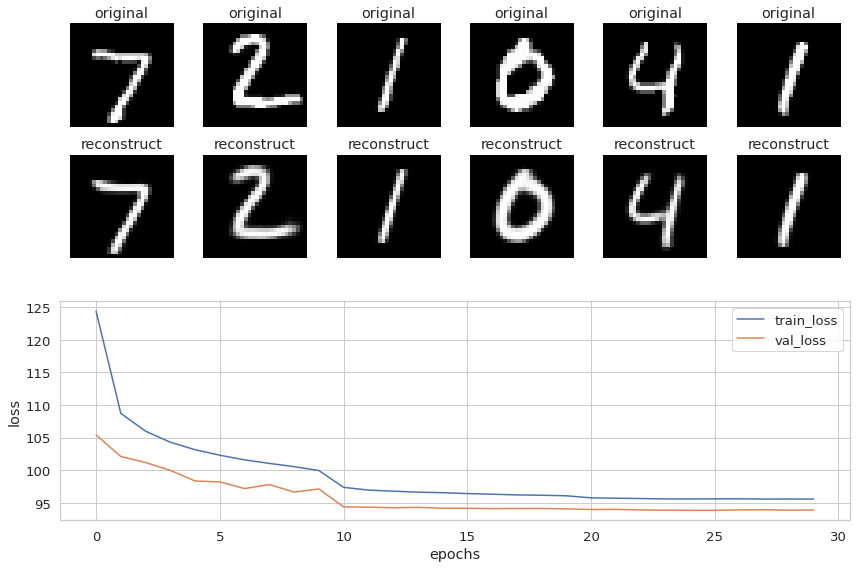

epoch: 100%|██████████| 30/30 [37:18<00:00, 74.62s/it]

Training is done! Best epoch 26, best time 1937.8322603702545, best val loss 93.85539470214843, best train loss 95.61953126220703


In [ ]:
epochs = 30
vae = train_model(train_loader, test_loader, vae,
                  'vae', epochs, criterion, optimizer, scheduler)

<a id='reconstruction_vae'></a>
## Reconstruction VAE

Давайте посмотрим на то, как наш VAE кодирует и восстанавливает цифры. Для этого прогоним несколько изображений через вариационный автоэнкодер и сравним изображения на входе и выходе VAE.

In [ ]:
# Загрузим обученный VAE
autoencoder = VAE().to(DEVICE)
autoencoder.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_vae.pth')))

<All keys matched successfully>

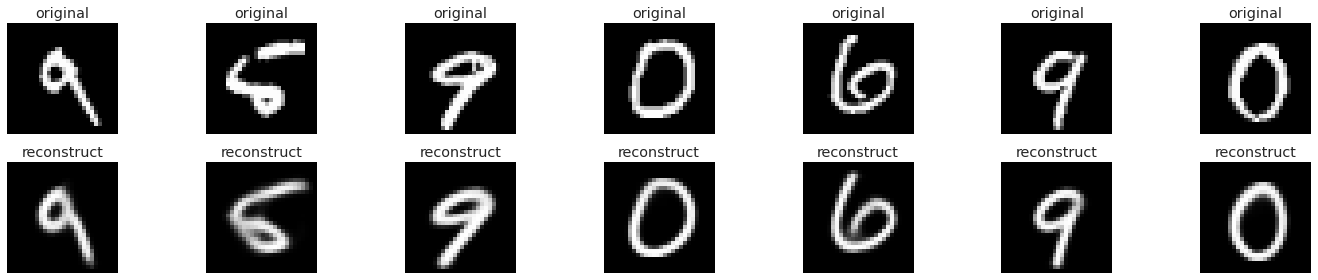

In [ ]:
x_val, labels = next(iter(test_loader))
x_val_np = x_val.detach().squeeze(1).numpy()

with torch.no_grad():
    mu, logsigma, x_reconstr = autoencoder(x_val.to(DEVICE))
    x_reconstr = x_reconstr.cpu().squeeze(1).numpy()

plt.figure(figsize=(20, 4))
for i in range(7):
    plt.subplot(2, 7, i+1)
    plt.axis("off")
    plt.imshow(x_val_np[i+7], cmap='gray')
    plt.title('original')

    plt.subplot(2, 7, i+8)
    plt.axis("off")
    plt.imshow(x_reconstr[i+7], cmap='gray')
    plt.title('reconstruct')

plt.tight_layout()
plt.show()

<a id='sampling_vae'></a>
## Sampling

Теперь проделаем с VAE то же самое, что и с обычным AE в [предыдущем блокноте](https://github.com/ivantipow/Autoencoders/blob/main/1_Vanilla_Autoencoder.ipynb). А именно, давайте не просто брать картинку, прогонять ее через VAE и получать реконструкцию, а генерировать новые цифры.

Для этого подадим на вход decoder'у VAE случайные векторы из нормального распределения и посмотрим, какие картинки получаются.

Для начала сгенерируем 25 векторов из нормального распределения в $ℝ^{dim}$ со средним 0 и дисперсией 1. Потом отобразим эти вектора с учетом распределения векторов (точек) реальных цифр в латентом пространстве, передадим их также на вход декодеру. Посмотрим и сравним получившиеся цифры до и после отображения случайно сгенерированных векторов.

In [ ]:
# Загрузка обученного VAE
vae = VAE().to(DEVICE)
vae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_vae.pth')))

<All keys matched successfully>

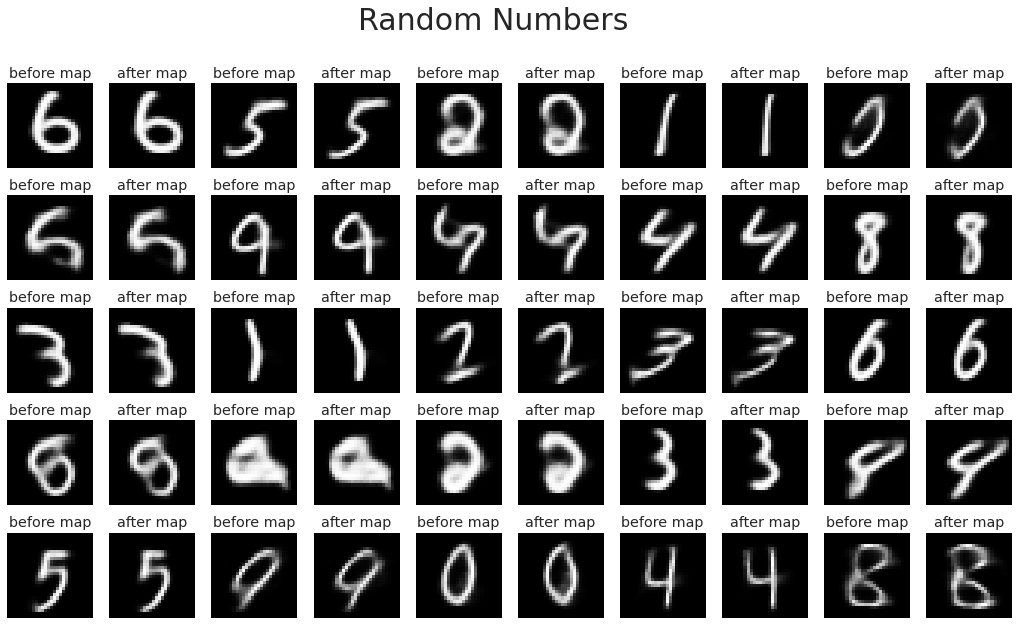

In [ ]:
# Генерируем 25 рандомных векторов размера latent_space (dim_vae)
z = torch.randn(25, dim_vae)

# Прогоняемм их через decoder и получая случайно сгенерированные цифры
with torch.no_grad():
    output_raw = vae.decode(z.to(DEVICE)).cpu().squeeze(1).numpy()

# У нас на валидации всего 10000 картинок. Это достаточно много. Потому далее
# будем работать с одним батчем (64 картинки)
batch, _ = next(iter(test_loader))

# Пропустим все эти изображения через энокдер.
# Получим 64 вектора в латентом пространстве
with torch.no_grad():
    mu, _ = vae.encode(batch.to(DEVICE))

# Найдем средний по батчу вектор в латентном пространстве
latent_mu = mu.cpu().mean(0).unsqueeze(0)

# Преобразуем наши вектора z из распределения (mu=0, std=1)
mapping_z = latent_mu + z

# Прогоним получившиеся вектора через decode
with torch.no_grad():
    output = vae.decode(mapping_z.to(DEVICE)).cpu().squeeze(1).numpy()

# Отрисуем получившиеся изображения
plt.figure(figsize=(18, 10))
plt.suptitle('Random Numbers', fontsize=30)
for i in range(25):
    plt.subplot(5, 10, 2*i+1)
    plt.axis("off")
    plt.imshow(output_raw[i], cmap='gray')
    plt.title('before map')
    # Под map'ом тут понимается отображение сгенерированных векторов
    # из распределения (mu=0,std=1) в (mu, std)

    plt.subplot(5, 10, 2*i+2)
    plt.axis("off")
    plt.imshow(output[i], cmap='gray')
    plt.title('after map')

plt.show()

<a id='latent_rep'></a>
## Latent Representation

Давайте посмотрим, как латентные векторы картинок цифр выглядят в пространстве.
Для этого изобразим латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Также давайте покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет.

Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (возьмем из `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
# Загрузим обученный VAE
vae = VAE().to(DEVICE)
vae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_vae.pth')))

<All keys matched successfully>

In [ ]:
labels = np.zeros(1)
latent_vectors = np.zeros((1, 8))

# Получим латентные представление картинок (цифр) тестового датасета
with torch.no_grad():
    vae.eval()
    for inputs, label in test_loader:
        inputs = inputs.to(DEVICE)
        lat_vect_batch, _ = vae.encode(inputs)
        latent_vectors = np.concatenate(
            (latent_vectors, lat_vect_batch.cpu().numpy()))
        labels = np.concatenate((labels, label.numpy()))

labels = np.delete(labels, 0, axis=0)
latent_vectors = np.delete(latent_vectors, 0, axis=0)

print(f'Размеры полученных латентных векторов {latent_vectors.shape}.')
print(f'Размеры полученных лейблов латентных векторов {labels.shape}.')

Размеры полученных латентных векторов (10000, 8).
Размеры полученных лейблов латентных векторов (10000,).


In [ ]:
# Запишем латентные векторы и их лейблы в файл
dict_latent_vae = {
    'latent_vectors': latent_vectors,
    'labels': labels
}

with open(os.path.join(DATA_DIR, 'dict_latent_vae.pickle'), 'wb') as f:
    pickle.dump(dict_latent_vae, f)

In [ ]:
# Загрузим латентные векторы и лейблы из словаря
with open(os.path.join(DATA_DIR, 'dict_latent_vae.pickle'), 'rb') as f:
    dict_latent_vae = pickle.load(f)

In [ ]:
# Сожмем латентные векторы до размерности 2, используя TSNE
latent_vectors = dict_latent_vae['latent_vectors']

tsne_vectors = TSNE(
    n_components=2, random_state=42).fit_transform(latent_vectors)
tsne_vectors.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(10000, 2)

In [ ]:
dict_latent_vae['tsne_vectors'] = tsne_vectors
with open(os.path.join(DATA_DIR, 'dict_latent_vae.pickle'), 'wb') as f:
    pickle.dump(dict_latent_vae, f)

In [ ]:
# Загрузим латентные векторы и лейблы из словаря
with open(os.path.join(DATA_DIR, 'dict_latent_vae.pickle'), 'rb') as f:
    dict_latent_vae = pickle.load(f)

latent_vectors = dict_latent_vae['latent_vectors']
labels = dict_latent_vae['labels']
tsne_vectors = dict_latent_vae['tsne_vectors']

Визуализируем полученные двумерные представления

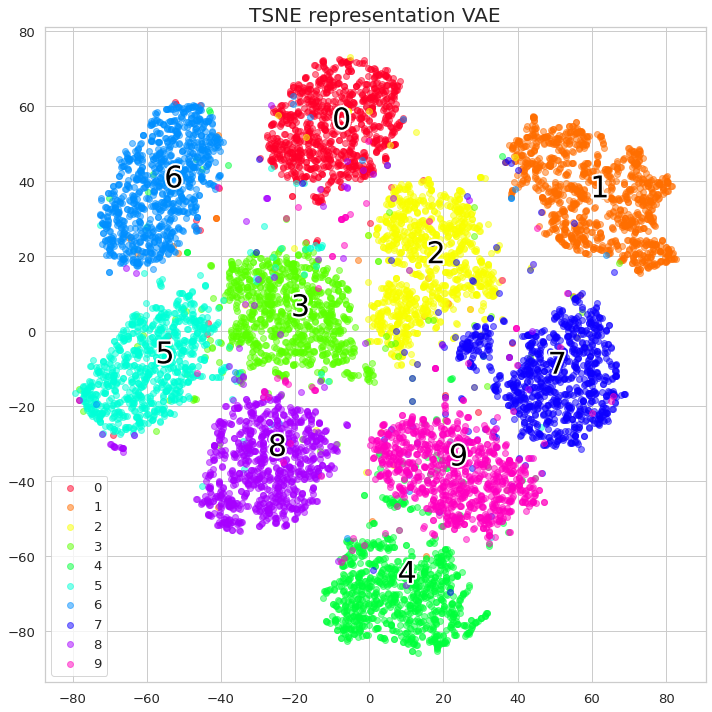

In [ ]:
colors = cm.gist_rainbow(np.linspace(0, 1, len(np.unique(labels))))

plt.figure(figsize=(10, 10))
for label, color in zip(np.unique(labels), colors):
    plt.scatter(tsne_vectors[labels == label, 0],
                tsne_vectors[labels == label, 1],
                c=color.reshape(1, -1),
                alpha=0.5,
                label=str(int(label))
                )
    x = np.mean(tsne_vectors[labels == label, 0])
    y = np.mean(tsne_vectors[labels == label, 1])
    plt.text(x, y, str(int(label)),
             fontsize=30,
             c='black',
             path_effects=[
        path_effects.Stroke(linewidth=4, foreground='white'),
        path_effects.Normal()
    ],
    )

plt.title('TSNE representation VAE', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

Видим, что : 

1.   При отображении точек из латентного пространства на плоскость кластеры всех цифр хорошо разделяются. Потому можно считать, что и в латентном пространстве (размерности 8) эти кластеры хорошо разделены.
2.   Кластеры, соответствующие цифрам со схожей геометрией, находятся рядом. Например, 0-6, 8-9, 1-7 или 5-3. Это говорит о том, что в латентном пространстве кластеры соответствующих цифр, скорее всего, находятся также рядом.
3.   Кластеры, соответствующие цифрам с сильно отличающейся геометрией, находятся далеко друг от друга. Например, 5-1, 6-7 и др.
